<a href="https://colab.research.google.com/github/ChristianConchari/Computer-Vision-Notes/blob/master/Tutorial_17_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 17: Convolutional Neural Networks

Working with CNNs in pytorch follows similar steps as you did with neural networks: 

- Load and normalize the dataset using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In this notebook, you will work again with Fashion MNIST but with a CNN instead of a regular neural network. 

## 1. Import libraries and the dataset. Display samples. 

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)

# print details of the imported subsets
print("Trainset: ",train_data)
print("Testset: ",test_data)

# prepare data loaders, set the batch_size
# consider changing the batch size because this can also have effects in the 
# accuracy of your CNN
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!
Trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Testset:  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize an entire batch 

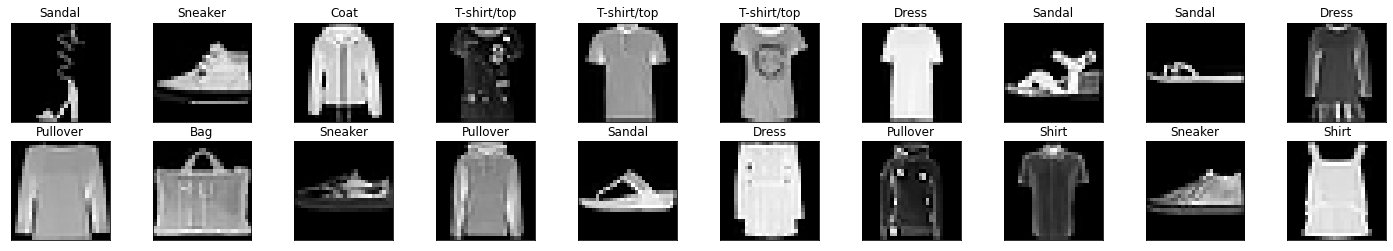

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## 2. Define the network architecture

The various layers that make up any neural network are documented [here](http://pytorch.org/docs/stable/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

Similarly as you did with neural networks, you define the layers of a CNN model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. 

Recommendations/tips:
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting




In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3) #(in_channels, out_channels, kernel_size)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # 20 outputs * the 5*5 filtered/pooled map size
        self.fc1 = nn.Linear(20*5*5, 256)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        # intermidiate layer 
        self.fc2 = nn.Linear(256, 64)
        # finally, create 10 output channels (for the 10 classes)
        self.fc3 = nn.Linear(64, 10)
        

    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # three linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=256, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

# move model to GPU
net.cuda()
# define a loss function
criterion = nn.NLLLoss()
# stochastic gradient descent with a small learning rate AND some momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3. Train the network

In [ ]:
# this time we will define a function which takes in a number of epochs to train for. 
# this function return the total loss over time, which you can visualize if needed
def train(n_epochs):
    
    # to track the loss as the network trains
    loss_over_time = [] 
    
    # loop over the dataset multiple times
    for epoch in range(n_epochs):  
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs.cuda())

            # calculate the loss
            loss = criterion(outputs, labels.cuda())

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print("Epoch: ",epoch + 1," Batch:",batch_i+1, "Avg. Loss: ",avg_loss  )
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

# define the number of epochs to train for
n_epochs = 35

# call train
training_loss = train(n_epochs)

Epoch:  1  Batch: 1000 Avg. Loss:  0.22951574048027396
Epoch:  1  Batch: 2000 Avg. Loss:  0.22447918320074678
Epoch:  1  Batch: 3000 Avg. Loss:  0.23832653196714818
Epoch:  2  Batch: 1000 Avg. Loss:  0.22099332403298466
Epoch:  2  Batch: 2000 Avg. Loss:  0.2225504624210298
Epoch:  2  Batch: 3000 Avg. Loss:  0.22136229450814426
Epoch:  3  Batch: 1000 Avg. Loss:  0.21282218102738262
Epoch:  3  Batch: 2000 Avg. Loss:  0.21573027619998902
Epoch:  3  Batch: 3000 Avg. Loss:  0.2216697852574289
Epoch:  4  Batch: 1000 Avg. Loss:  0.21056283781398089
Epoch:  4  Batch: 2000 Avg. Loss:  0.21548689546622335
Epoch:  4  Batch: 3000 Avg. Loss:  0.20901465866388752
Epoch:  5  Batch: 1000 Avg. Loss:  0.19825920443423092
Epoch:  5  Batch: 2000 Avg. Loss:  0.20848079094849528
Epoch:  5  Batch: 3000 Avg. Loss:  0.21227392913587392
Epoch:  6  Batch: 1000 Avg. Loss:  0.19785908312443642
Epoch:  6  Batch: 2000 Avg. Loss:  0.1979451978839934
Epoch:  6  Batch: 3000 Avg. Loss:  0.20864376013725996
Epoch:  7  Ba

## 4. Evaluate the model


In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()
# move to cpu
net.to('cpu')

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss:',test_loss.numpy()[0])

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of ',classes[i],':', 100 * class_correct[i] / class_total[i],'%')
    else:
        print('Test Accuracy of ',classes[i],': No training examples')

Test Loss: 0.38805485
Test Accuracy of  T-shirt/top : 78.7 %
Test Accuracy of  Trouser : 97.7 %
Test Accuracy of  Pullover : 82.2 %
Test Accuracy of  Dress : 86.6 %
Test Accuracy of  Coat : 82.8 %
Test Accuracy of  Sandal : 96.8 %
Test Accuracy of  Shirt : 78.0 %
Test Accuracy of  Sneaker : 96.6 %
Test Accuracy of  Bag : 98.4 %
Test Accuracy of  Ankle boot : 95.9 %


### Visualize a sample test result

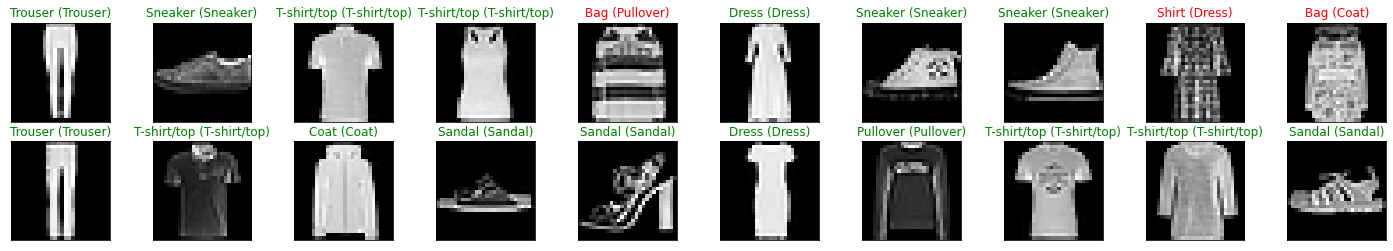

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(""+str(classes[preds[idx]])+" ("+str(classes[labels[idx]])+")",color=("green" if preds[idx]==labels[idx] else "red"))

# Exercise 1: Evaluation metrics

It's getting fascinating, isn't it? Now try to define what problems this CNN has, what could be improved? 

For this exercise, you will have to find (and visualize when possible) the evaluation metrics defined in the video 9.3 Training optimization: Evaluation accuracy, LogarithmicLoss, Confusion Matrix, AUC, and F1 Score. You can use cuda (GPU) to speed up the training. 


### Evaluation Accuracy

The following formula will be used for calculating the Total Evaluation Accuracy of the model.

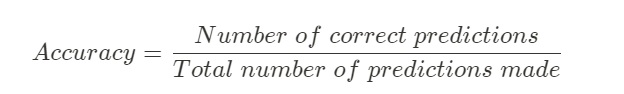

In this case, in our training set we have 10 classes where in each one we will have 1000 elements, making a total of 10000 elements which is the total size of our testing set, it is important to highlight this because the Classification Accuracy metric is only a valid metric when we have the same number of elements present in each one of the classes we work with. The code implementation is presented in the following cell.

In [ ]:
# set the module to evaluation mode
net.eval()
total_predictions = 0
correct_predictions = 0
for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for all the object class
    for i in range(batch_size):
        correct_predictions += correct[i].item()
        total_predictions += 1

print(f'Test Accuracy of the model with {total_predictions} elements and {correct_predictions} correct predictions: {round(100 * correct_predictions / total_predictions,2)}%')

Test Accuracy of the model with 10000 elements and 8937 correct predictions: 89.37%


As can be seen, a fairly good accuracy rate was obtained, being close to 90%. This could mean that the model obtained is good enough and the training was done properly.

### Logarithmic Loss

The following formula is used to calculate the logarithmic loss.

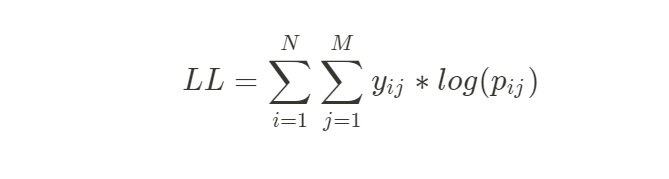

Where:

- $y_{ij}$ indicates whether sample $i$ belongs to class $j$ or not.
- $p_{ij}$ indicates the probability of sample $i$ belonging to class [0,1].
- Logaritmic Loss has no upper bound [0,$\infty$).

The next thing we will do is to obtain a vector with the percentages of belonging of each image to a certain class (values between 0 and 1) and another one with the prediction made of an image for a certain class (0 or 1). 

In [ ]:
class_probability = []
class_label = []

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
  # get the input images and their corresponding labels
  inputs, labels = data

  # Pass an avaluation image
  with torch.no_grad():
    # forward pass to get outputs
    outputs = net(inputs)

  # Output of the network are logits, need to take softmax for probabilities
  ps = F.softmax(outputs, dim=1)
  ps = ps.data.numpy().squeeze()

  preds = np.squeeze(net(inputs).data.max(1, keepdim=True)[1].numpy())
  labels = labels.data.numpy().squeeze()

  for i in range(batch_size):
      if (preds[i] == labels[i]):
        class_label.append(1)
      else:
        class_label.append(0)
      class_probability.append(round(np.max(ps[i]),4))

for i in range(10000):
  print(f'For prediction percentage: {class_probability[i]} label: {class_label[i]}')

Streaming output truncated to the last 5000 lines.
For prediction percentage: 0.9143000245094299 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 0.9973000288009644 label: 1
For prediction percentage: 0.38499999046325684 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 0.9883999824523926 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 0.7228999733924866 label: 0
For prediction percentage: 0.9991000294685364 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 0.9998000264167786 label: 0
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 1.0 label: 1
For prediction percentage: 0.6306999921798706 label: 1
For prediction percentage: 0.9993000030517578 label: 1
For predictio

With these results we can now calculate the logarithmic loss for the results obtained with the test dataset.

In [ ]:
def cross_entropy(actual, predicted):
  loss = -np.sum(actual * np.log(predicted))
  return loss

loss = cross_entropy(class_label, class_probability)
print(loss)

344.7488650257583


The value obtained indicates the existence of poor predictions in our model, which could mean that there are still parameters to improve when training the model. It should also considered that the logarithmic loss calculation is using a function created with the theoretical knowledge acquired, and it is not a built-in py-torch function, so it should not be taken as the most optimal or the most accurate result.

### Confusion Matrix

To present the confusion matrix, the following code was implemented using the Seaborn, Pandas and Scikit Learn data visualisation and extraction modules.

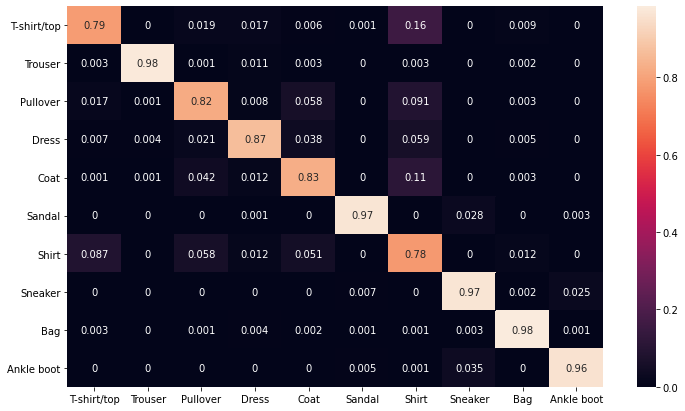

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

predicted = []
trained = []

for inputs, labels in test_loader:
        # forward pass to get outputs
        output = net(inputs) 
        # get the predicted class from the maximum value in the output-list of class scores
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        predicted.extend(output) 
        labels = labels.data.cpu().numpy()
        trained.extend(labels) 

# Confussion matrix build
cf_matrix = confusion_matrix(trained, predicted)
cf_matrix_plot = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix_plot, annot=True)

As can be seen, good results were obtained for predictions for the different classes. Where the values we are most interested in are the TPs, which lie on the main diagonal of the confusion matrix. In the case of the model obtained, with values greater than or close to 80% in most cases, so that according to this metric it can be considered that the training of the model has been adequate.

### Area Under the Curve (AUC)

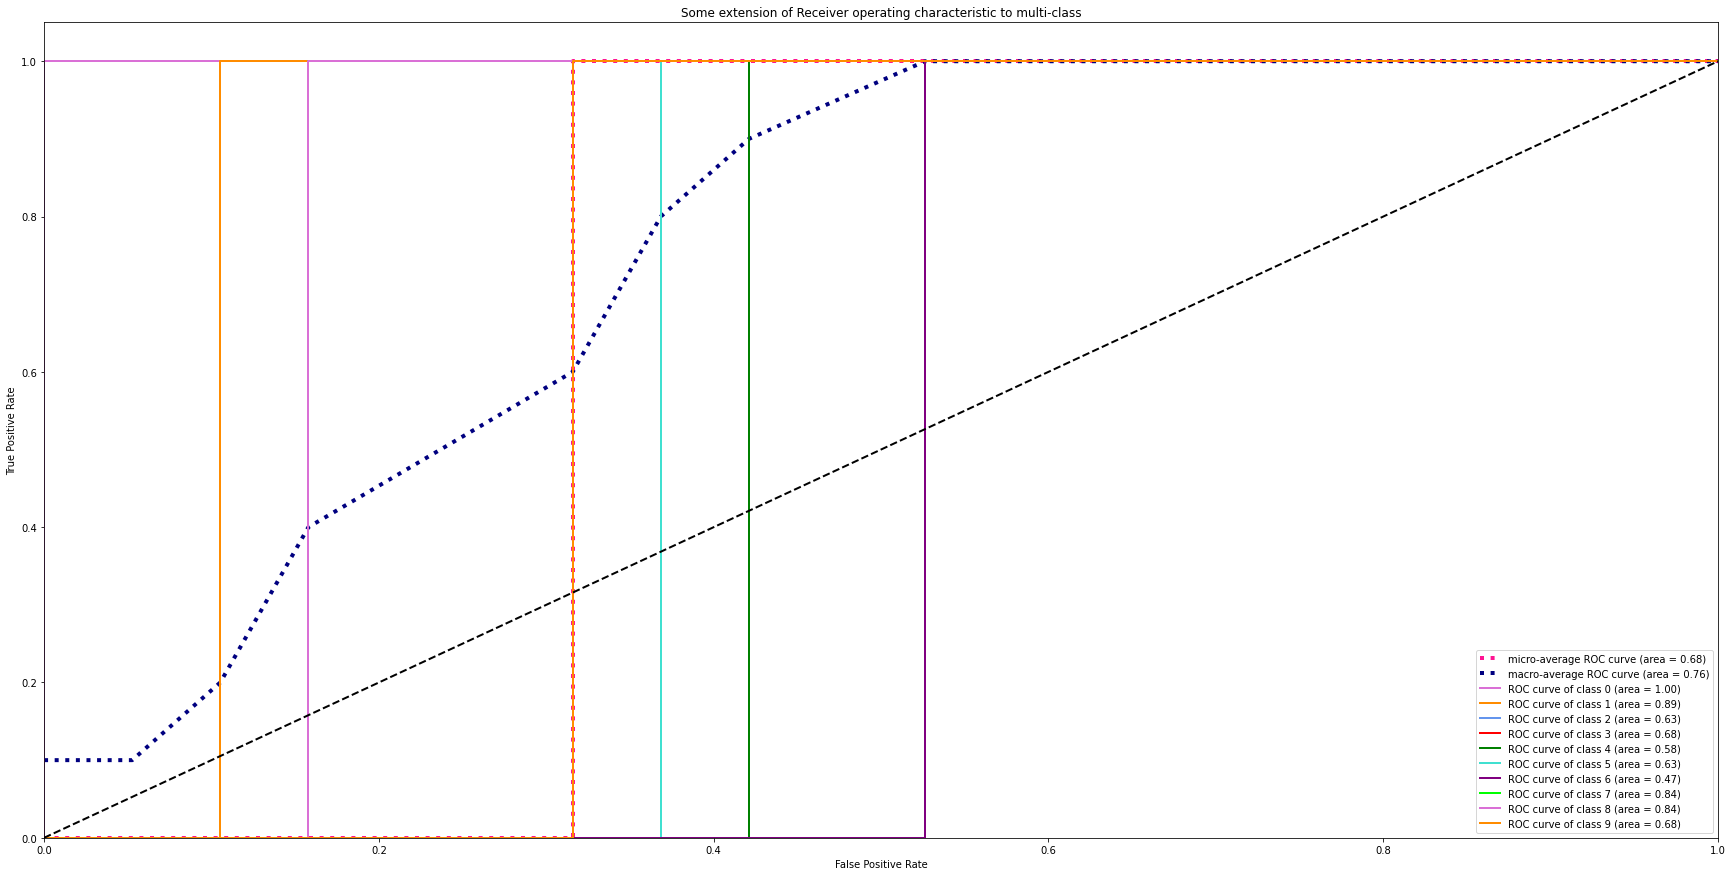

In [ ]:
from sklearn import metrics
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 10

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
  fpr[i], tpr[i], _ = metrics.roc_curve(preds, ps[:,i], pos_label = 0)
  roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(preds.ravel(), ps[:,i].ravel(), pos_label = 0)
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plotting the ROC to multi-class
plt.figure(figsize=(30, 15))
plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['orchid', 'darkorange', 'cornflowerblue', 'red', 'green', 'turquoise', 'purple', 'lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label='ROC curve of class {0} (area = {1:0.2f})'
                    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

As can be seen in the results, graphs were obtained for each class. Emphasizing the value of the area under the ROC macro average curve, this indicates the existence of good predictions in our model, which indicates that the training parameters of the model, were choosen good. In addition, it should be noted that the graphs were obtained by performing a test of results with a batch size equal to 20, therefore it is also recommended to modify this value to make an improvement before training.

### F1 Score

The following code was implemented to find the F1 score, remembering that we need information obtained from the confusion matrix to obtain this metric.

In [ ]:
import sklearn.metrics as metrics
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(trained, predicted)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.82      0.84      1000
           3       0.93      0.87      0.90      1000
           4       0.84      0.83      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.65      0.78      0.71      1000
           7       0.94      0.97      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.89      0.90     10000




We can see the results calculated for the present model in the third column with the title F1 Score, note that each row corresponds to a class of the model. Another way to obtain this metric is as follows, we can use it as a comparison.

In [ ]:
print("F1 score: \n",(metrics.f1_score(trained, predicted,average=None)))

F1 score: 
 [0.82624672 0.98537569 0.83706721 0.89694459 0.83383686 0.97679112
 0.7062019  0.9507874  0.97425743 0.96478873]


Note that fairly similar results were obtained by both methods, so that the calculations could be considered correct.

It is important to mention that for all classes percentages higher than 70% and in some cases close to or higher than 90% are achieved, which shows that the training of the model was adequate.